# ¿Cómo comparar diferentes modelos para predecir la probabilidad de no pagar un préstamo?

In [1]:
### Paquetes relevantes
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Introducción (5 mts)

**Contexto de negocios.** Eres un científico de datos en un banco que se ha dado cuenta que los modelos de regresión que usa para predicción, se comportan mucho peor cuando están en producción que cuando se hacían pruebas con ellos.

**Problema** Construir un modelo que funcione en producción.

**Contexto analítico.** 5000 observaciones sobre préstamos dentro del banco

1. El archivo **"loan_light.csv"** contiene los detalles de los préstamos
2. El archivo **"loan_param.xlsx"** contiene la descripción de cada variable

## Exploración de datos (40 mts)

In [2]:
Data = pd.read_csv("loan_light.csv")
Data = Data.sample(frac=1)  #muestra de los datos

In [3]:
Data.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
2912,65000.0,Individual,64076.0,0.0,2.0,16.31,10,C,0.0,512.60,...,1.0,0.0,MORTGAGE,36,1.0,0.0,home_improvement,2016,0,assistant
3400,82000.0,Individual,16452.0,0.0,0.0,12.85,10,C,2.0,723.03,...,1.0,0.0,OWN,60,4.0,0.0,debt_consolidation,2016,0,nurse
3426,79000.0,Individual,23881.0,0.0,0.0,7.20,10,C,0.0,661.11,...,3.0,0.0,MORTGAGE,60,1.0,0.0,debt_consolidation,2016,1,carrier
4941,50000.0,Individual,27307.0,0.0,0.0,32.50,1,D,5.0,322.62,...,3.0,1.0,MORTGAGE,36,6.0,0.0,debt_consolidation,2016,0,operator
3578,60000.0,Individual,10381.0,0.0,1.0,24.78,3,A,5.0,740.73,...,6.0,0.0,MORTGAGE,36,2.0,0.0,debt_consolidation,2016,1,supervisor


In [8]:
Data.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [4]:
df_description = pd.read_excel('loan_param.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


### Ejercicio 1: (20 mts)

Realizar cada visualización

#### 1.1 

Gráfico de barras del número de préstamos que se pagaron y los que no

**Respuesta.** Pista: utilice la función sns.countplot con la variable 'loan_default'

Text(0.5, 1.0, 'Loan Default')

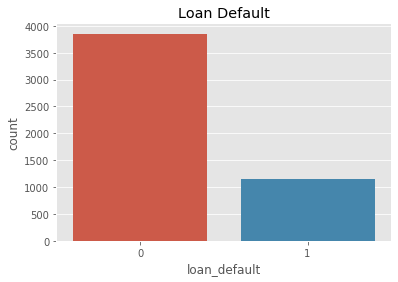

In [5]:
sns.countplot(x='loan_default', data = Data)
plt.title("Loan Default")

Alrededor de 20% o 25% de los préstamos están morosos

#### 1.2 

Histograma de los ingresos anuales

**Respuesta.**

Text(0.5, 0, 'Annual Income')

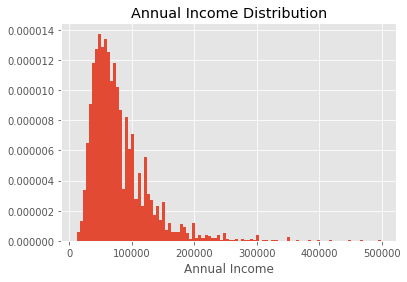

In [6]:
Data.annual_inc.hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

Los datos están algo sesgados, intentemos una transformación logarítmica para ver los datos más normalmente distribuidos

Text(0.5, 0, 'Annual Income')

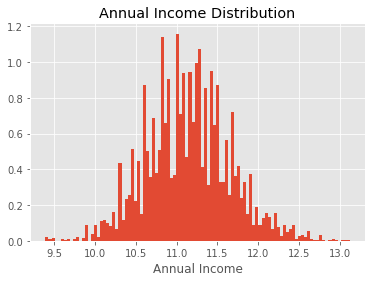

In [7]:
np.log(Data.annual_inc).hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")

#### 1.3

¿Es la distribución de ingresos anuales diferente entre aplicantes morosos y no morosos?

**Respuesta.** 

Text(0.5, 1.0, 'Annual Salary -- Loan Status')

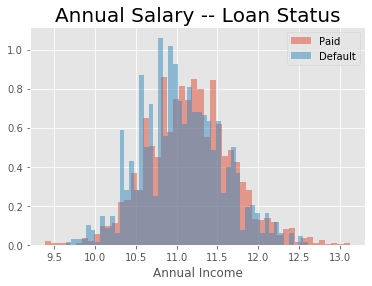

In [8]:
np.log(Data['annual_inc'][Data.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label="Paid")
np.log(Data['annual_inc'][Data.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("Annual Income")
plt.legend()
plt.title("Annual Salary -- Loan Status", fontsize=20)

Las distribuciones no son muy diferentes, por lo que el ingreso por sí solo no explica las diferencias entre pagar o no los préstamos

#### 1.4

Explora la asociación entre ingreso anual y los pagos mensuales.

**Respuesta.** Pista: utilice la función sns.joint entre las variables 'installment' y 'annual_inc', adicionalmente con el argumento: kind='hex'

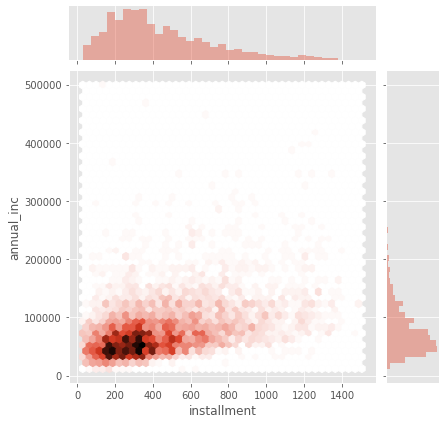

In [9]:
sns.jointplot(Data.installment, Data.annual_inc, kind = 'hex')

Ambas distribuciones están sesgadas de un modo similiar, utilice ahora la transformación logarítmica:

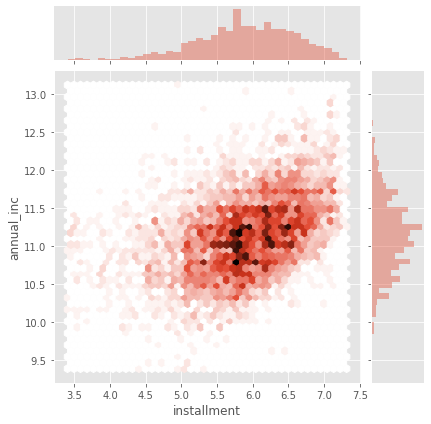

In [10]:
sns.jointplot(np.log(Data.installment), np.log(Data.annual_inc), kind="hex")

Parece haber una relación lineal en los logaritmos de las variables

Estos son otros gráficos que exploran la relación entre otras variables numéricas y la probabilidad de no pagar, incluyendo el ingreso anual:

`emp_length`:

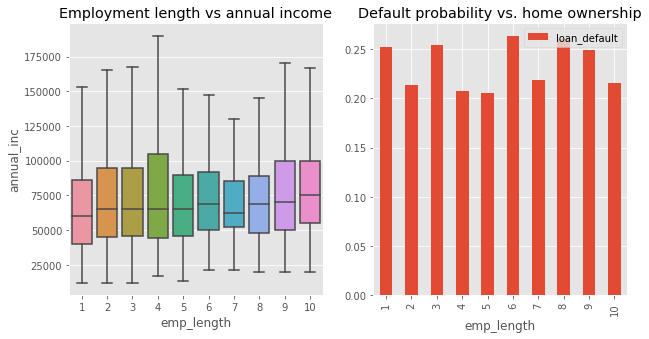

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = Data, showfliers=False, ax = ax1) #showfliers=False para que se vea bien
ax1.set_title("Employment length vs annual income")
Data[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

`homeOwnership`:

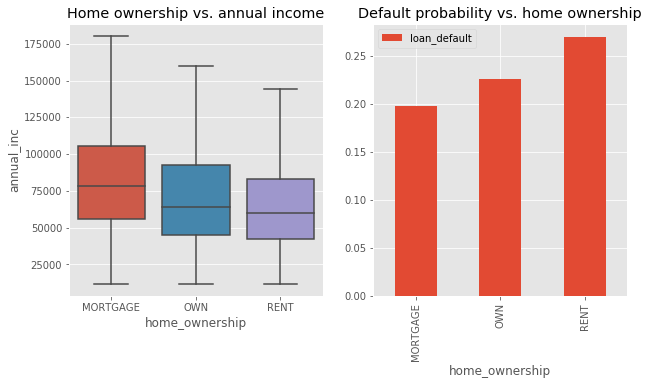

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = Data, showfliers=False, ax = ax1) #showfliers=False para que se vea bien
ax1.set_title("Home ownership vs. annual income")
Data[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership");

Por otro lado, estas gráficas muestran la relación entre varias variables categóricas y la probabilidad de no pagar:

`purpose`:

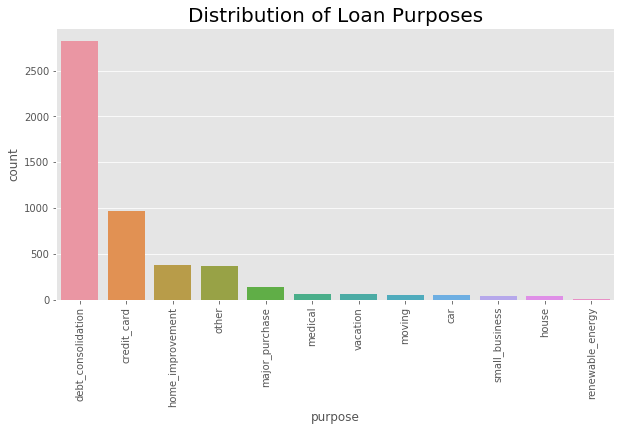

In [13]:
plt.figure(figsize= (10,5))
#Data.emp_length.value_counts()
sns.countplot(x='purpose', order=Data['purpose'].value_counts().index, data = Data) 
plt.xticks(rotation=90)
plt.title("Distribution of Loan Purposes", fontsize=20);

Text(0.5, 1.0, 'Default Probability by Loan Purpose')

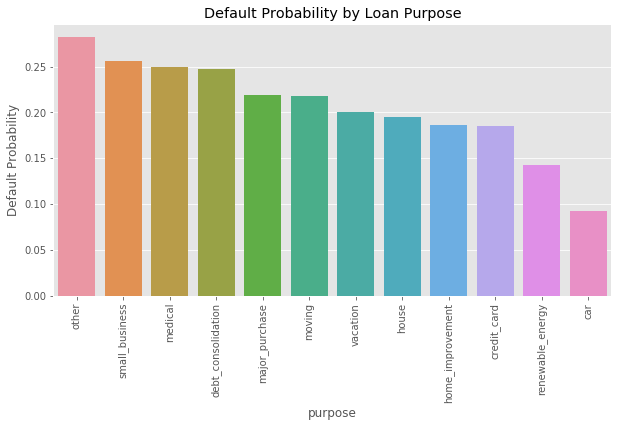

In [14]:
plt.figure(figsize= (10,5))
purpose_default = Data[["loan_default", "purpose"]].groupby("purpose").mean()
purpose_default = purpose_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=purpose_default.index[:30], 
            y=purpose_default["loan_default"][:30].values,
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Default Probability");
plt.title("Default Probability by Loan Purpose")


`job`:

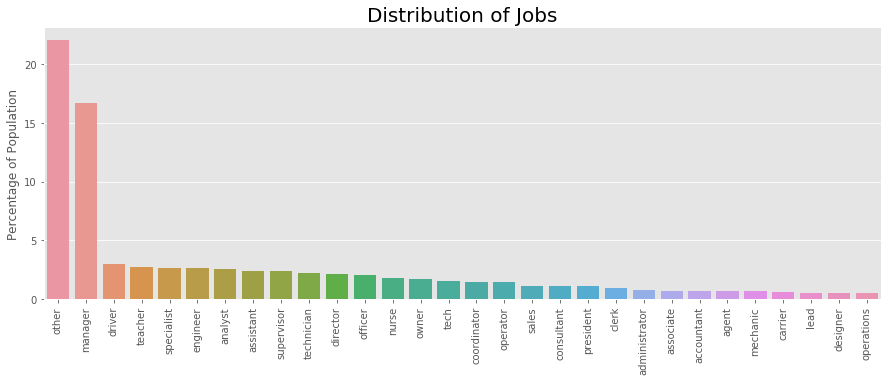

In [15]:
plt.figure(figsize= (15,5))
sns.barplot(x=Data["job"].value_counts()[:30].index.values , 
            y=100 * Data.job.value_counts()[:30].values / len(Data),
            orient="v")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);


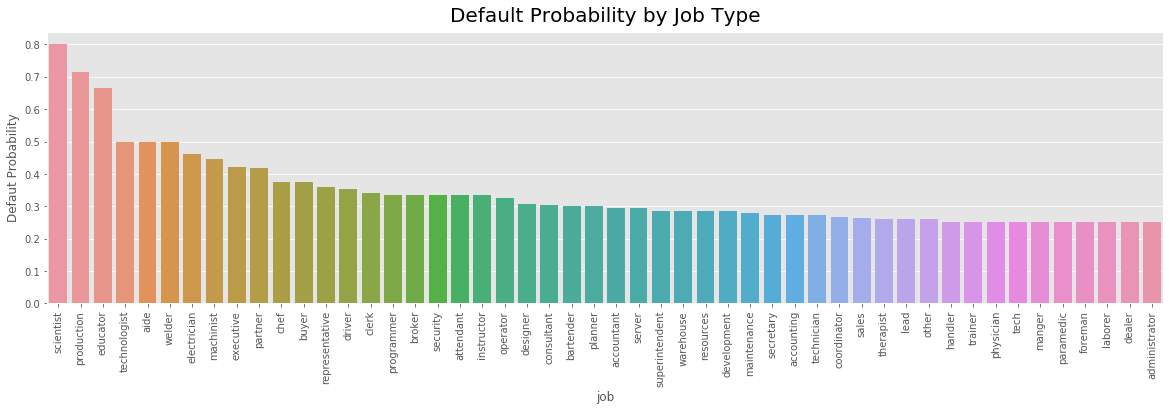

In [16]:
plt.figure(figsize= (20,5))

df_job_default = Data[["loan_default", "job"]].groupby("job").mean()
df_job_default = df_job_default.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_job_default.index[:50], 
            y=df_job_default["loan_default"][:50].values,
            orient="v")
plt.xticks(rotation=90)

plt.ylabel("Defaut Probability")
plt.title("Default Probability by Job Type", fontsize=20, verticalalignment='bottom');

### Añadiendo una variable

El pago anual, como una fracción de su ingreso anual, es una medida estándar utilizada en estos temas. Definamos una nueva variable: **"install_income"** que contiene el pago como fracción del ingreso anual.


Text(0.5, 0, 'Installment / Income')

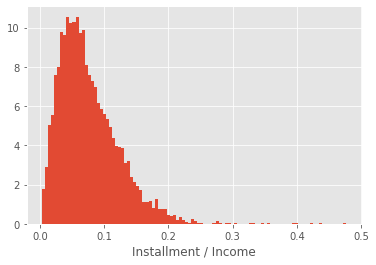

In [17]:
Data['install_income'] = 12 * Data.installment / Data.annual_inc
H = plt.hist(Data['install_income'], bins=100, density=True)
plt.xlabel(r"Installment / Income")

Para investigar la asociación con la probabilidad de no pagar, creamos una nueva variable llamada `install_income_disc`, la cual es una versión discretizada de `install_income`

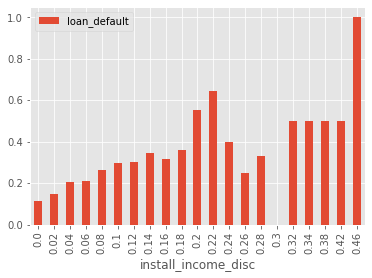

In [18]:
# Discretizando
Data["install_income_disc"] = (Data.install_income*50).astype(int)/50.
Data[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
Data = Data.drop(["install_income_disc"], axis=1)

# Así como la nueva variable se incrementa, la probabilidad de no pagar también; hay una asosiación positiva

### Ejercicio 2: (10 mts)

Visualizar la matriz de correlaciones entre todas las variables numéricas usando `sns.heatmap()`:

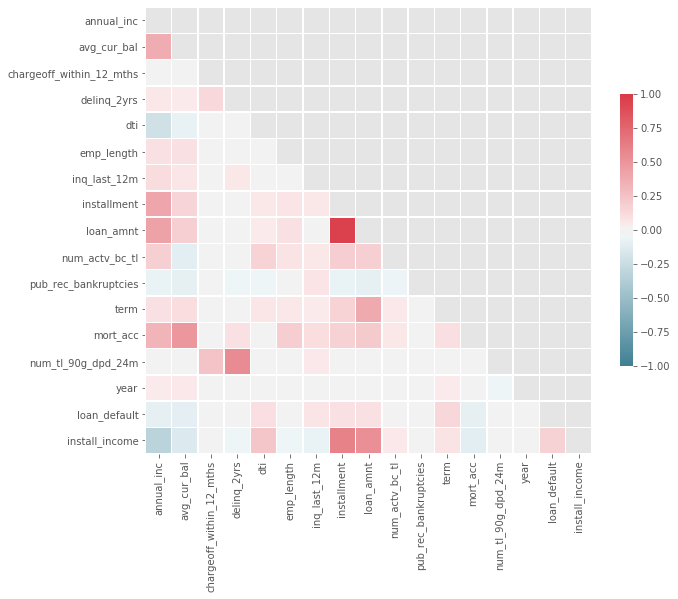

In [19]:
# Matriz de correlaciones
df_correlations = Data.corr()

# Máscara sobre la mitad superior con propósitos de visualzación
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Mapa de calor con máscara y corregir relación de aspecto
plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Modelo predictivo (20 mts)

Modelo logístico estándar.

### Ejercicio 3: (15 mts)

#### 3.1

Usar la función `LogisticRegression()` del paquete `scikit-learn`

**Respuesta.**

In [20]:
from sklearn.linear_model import LogisticRegression
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    clf = LogisticRegression(solver='lbfgs', tol=10**-4,  
                             fit_intercept=True, 
                             multi_class='multinomial').fit(X,y)
    return clf

#### 3.2
Regresión logística básica con solo la característica `install_income`. Llama a este modelo `model1`. Usa una partición de 70/30 de los datos.

**Respuesta.**

In [22]:
# split de 70/30 de entrenamiento y validación
n_total = len(Data)
n_train = int(0.7*n_total)

X, y = Data[["install_income"]], Data.loan_default
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [23]:
model1 = fit_logistic_regression(X_train, y_train)  # Ajustar regresión logística
y_test_pred = model1.predict_proba(X_test)[:,1]     # Predicciones probabilísticas sobre el conjunto de prueba

#### 3.3

Grafica la curva ROC de `model1` y encuentra el área bajo la curva.

**Respuesta.**

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

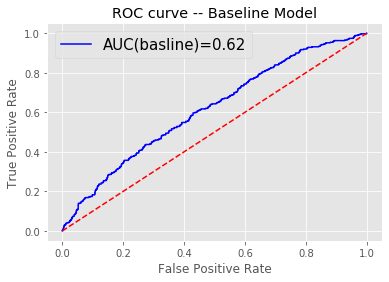

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)  # FPR/TPR
auc_baseline = auc(fpr, tpr) # AUC

plt.plot(fpr, tpr, "b-", label="AUC(basline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model");

### Ejercicio 4: (5 mts)

#### 4.1

Considere el modelo `model1`, ¿qué problema puede conllevar solo utilizar una variable respuesta?

**Answer.** Sub-ajuste.

#### 4.2

¿Estaría a favor de incluir todas las variables?

**Answer.** No, puede haber problema de sobre-ajuste.

## Validación cruzada (30 mts)

**Validación cruzada**
Técnica para verificar qué tan bien los resultados del modelo generalizan para otro conjunto de datos (ponerlo en producción).

Se parten los datos en $k$ conjuntos o **folds**. $k - 1$ de estos pligues son usados como conjunto de entrenamiento del modelo, mientras que el resto son usados como conjunto de prueba sobre el que el modelo será evaluado. Por estabilidad computacional, este proceso se repite varias veces y se calcula el AUC, así como la desviación estándar - El promedio de estos estadísticos es reportado.

![](cv_fig.png)

Este código muestra 5 pliegues con validación cruzada:

Text(0.5, 1.0, 'CROSS VALIDATION FOLDS')

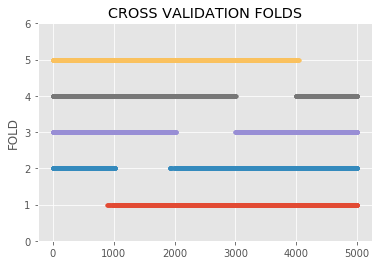

In [26]:
skf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,6)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

El siguiente código define una función que calcula el AUC:

In [27]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

### Ejercicio 5: (5 mts)

Función que realice 10 pliegues con validación cruzada y retorne una lista con el AUC de cada pliegue

**Respuesta**

In [28]:
def cross_validation_AUC(X,y, nfold=10):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=nfold)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

Vamos a comparar todos los modelos simples con validación cruzada, y como se discutió en el análisis exploratorio, se usarán las trasnformaciones logarítmicas para las variables `anual_income`, `loan_amount`, and `avg_cur_bal` 

In [29]:
# Solo los valores numéricos
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = Data.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["installment", "year"], axis=1)

# Escala logarítmica
Data_numerics["annual_inc"] = np.log10(Data_numerics["annual_inc"])
Data_numerics["loan_amnt"] = np.log10(Data_numerics["loan_amnt"])
Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])

Comparemos las estimaciones de AUC para cada modelo

In [30]:
model_perf = pd.DataFrame({}) #Dataframe vacío para rellenarlo con las estimaciones
for key in Data_numerics.keys():
    if key == "loan_default": continue
    X_full, y_full = Data_numerics[[key]], Data_numerics.loan_default
    auc_list = cross_validation_AUC(X_full, y_full, nfold=10)
    model_perf["SIMPLE:" + key] = auc_list

### Ejercicio 6: (5 mts)

Construye un diagrama de caja que muestre la distribución de las puntuaciones de cada modelo. ¿Cuál tiene mayor valor predictivo?

**Respuesta.**

In [31]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

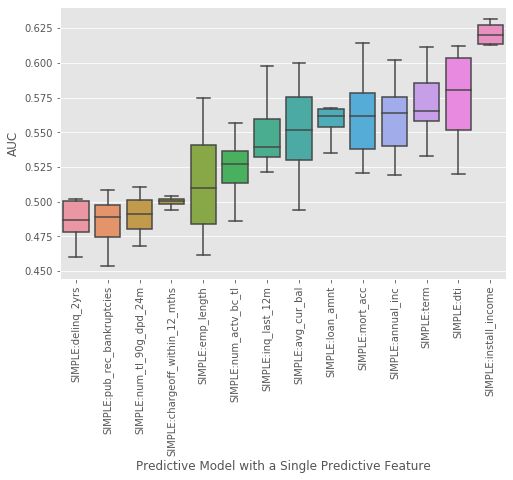

In [32]:
plt.figure(figsize= (8,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

### Ejercicio 7: (5 mts)

Modelo con todas las numéricas y ninguna categórica. VC de 10 pliegues.

In [33]:
X_full, y_full = Data_numerics.drop(["loan_default"], axis=1), Data_numerics.loan_default
auc_list = cross_validation_AUC(X_full, y_full)
model_perf["ALL_NUMERICAL"] = auc_list
model_perf

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income,ALL_NUMERICAL
0,0.519578,0.555302,0.493819,0.439199,0.529645,0.482672,0.597752,0.565415,0.552893,0.503875,0.564835,0.557711,0.468446,0.591810,0.643078
1,0.548518,0.600116,0.501295,0.496421,0.550768,0.485604,0.547802,0.561551,0.505147,0.484933,0.556063,0.588276,0.487853,0.612990,0.650373
2,0.519635,0.540280,0.499500,0.546916,0.600014,0.461390,0.563960,0.592855,0.518623,0.472116,0.602809,0.532997,0.503136,0.616421,0.687847
3,0.578837,0.597764,0.503896,0.460519,0.555517,0.544359,0.525172,0.553213,0.528922,0.493224,0.564370,0.614658,0.494986,0.620339,0.658475
4,0.537290,0.493890,0.502597,0.502180,0.612535,0.489577,0.539605,0.592580,0.556725,0.476115,0.611237,0.520870,0.494478,0.631440,0.692513
5,0.566719,0.576059,0.497820,0.501739,0.562021,0.574737,0.538871,0.561626,0.511858,0.492682,0.565274,0.566087,0.473597,0.630198,0.655020
6,0.564867,0.572456,0.503896,0.491948,0.519774,0.531711,0.521717,0.557188,0.526550,0.508752,0.587352,0.569328,0.482857,0.619469,0.657414
7,0.563693,0.526369,0.499548,0.478893,0.605647,0.483139,0.531372,0.567758,0.538803,0.474545,0.532637,0.553970,0.479503,0.629588,0.627623
8,0.587250,0.513506,0.500858,0.482010,0.599164,0.530333,0.567069,0.518916,0.527939,0.499447,0.580011,0.524935,0.510390,0.591519,0.667397
9,0.602405,0.548199,0.497380,0.478227,0.604325,0.555054,0.534568,0.534828,0.486302,0.453405,0.550085,0.581412,0.504404,0.621479,0.651519


Text(0, 0.5, 'AUC')

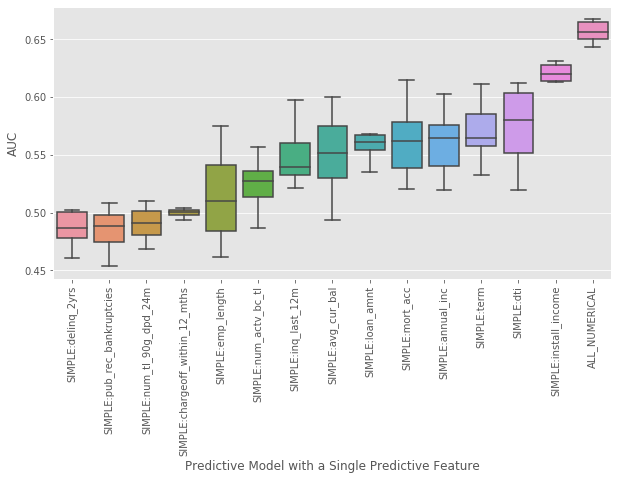

In [34]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

El modelo combinado rinde mejor que el de una sola característica.

## Incorporar variables categóricas (25 mts)

El grado del préstamo no ha sido utilizado, esta es su distribución:

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

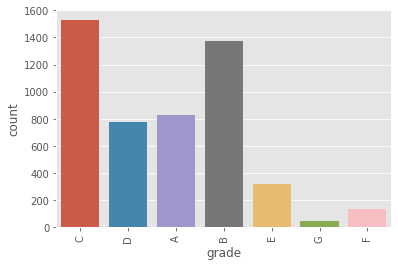

In [35]:
Data.emp_length.value_counts()
sns.countplot(x='grade', data = Data) 
plt.xticks(rotation=90)

In [36]:
# Convertirla en dummy
grade_categ = pd.get_dummies(Data['grade'], prefix = "grade", drop_first=True)
grade_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
2912,0,1,0,0,0,0
3400,0,1,0,0,0,0
3426,0,1,0,0,0,0
4941,0,0,1,0,0,0
3578,0,0,0,0,0,0


#### 8.2
Agregar esta característica a todas las variables numéricas

**Respuesta.**

In [37]:
X_grade = pd.concat([X_full,grade_categ],axis=1) 
X_grade.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
2912,4.812913,4.806702,0.0,2.0,16.31,10,0.0,4.176091,1.0,0.0,36,1.0,0.0,0.094634,0,1,0,0,0,0
3400,4.913814,4.216245,0.0,0.0,12.85,10,2.0,4.477121,1.0,0.0,60,4.0,0.0,0.105809,0,1,0,0,0,0
3426,4.897627,4.378071,0.0,0.0,7.20,10,0.0,4.440909,3.0,0.0,60,1.0,0.0,0.100422,0,1,0,0,0,0
4941,4.698970,4.436290,0.0,0.0,32.50,1,5.0,3.956649,3.0,1.0,36,6.0,0.0,0.077429,0,0,1,0,0,0
3578,4.778151,4.016281,0.0,1.0,24.78,3,5.0,4.380211,6.0,0.0,36,2.0,0.0,0.148146,0,0,0,0,0,0


In [38]:
auc_list = cross_validation_AUC(X_grade, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE"] = auc_list

Text(0, 0.5, 'AUC')

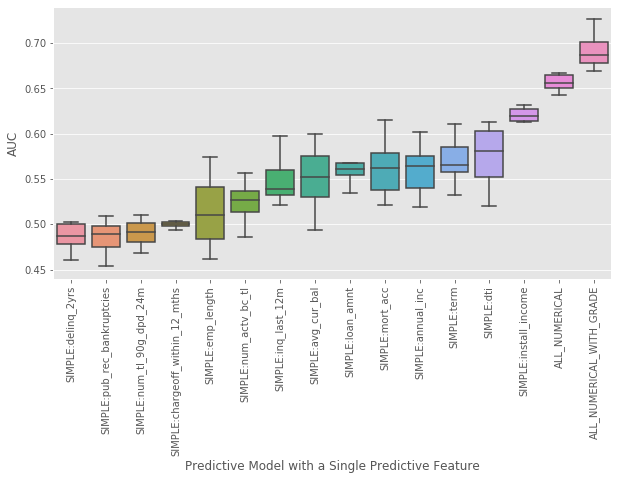

In [39]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC")

La diferencia es significativa